## Imports

In [1]:
from collections import defaultdict

import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from khan_helpers import Experiment
from khan_helpers.constants import (
    CV_PARAMS,
    FIG_DIR,
    LECTURE_WSIZE,
    LDA_PARAMS,
    MODELS_DIR,
    RAW_DIR, 
    STOP_WORDS,
    TRAJS_DIR
)
from khan_helpers.functions import (
    _ts_to_sec,
    interp_lecture,
    multicol_display,
    parse_windows,
    preprocess_text,
    show_source,
    synset_match
)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

## Inspect some things defined in `khan_helpers`

In [2]:
show_source(Experiment)

In [3]:
show_source(preprocess_text)

In [4]:
show_source(synset_match)

In [5]:
show_source(parse_windows)

In [6]:
show_source(_ts_to_sec)

In [7]:
show_source(interp_lecture)

In [8]:
show_source(multicol_display)

In [9]:
show_source(show_source)

In [10]:
def get_top_words(cv, lda, n_words=10):
    topic_words = {}
    vocab = cv.get_feature_names()
    for topic, component in enumerate(lda.components_):
        word_ix = np.argsort(component)[::-1][:n_words]
        topic_words[topic] = [vocab[i] for i in word_ix]
    return topic_words

## Inspect some raw data we're working with

In [11]:
exp = Experiment()
multicol_display(exp.forces_transcript[:309], 
                 exp.bos_transcript[:305], 
                 ncols=2, 
                 col_headers=['Four Fundamental Forces', 'Birth of Stars'],
                 cell_css={'text-align': 'left', 
                           'background-color': 'white', 
                           'padding-left': '10%'})

00:00.294What I want to do in this video is00:01.71give a very high-level overview of the four fundamental forces00:08.16of the universe.00:09.28And I'm going to start with gravity.00:14.21And it might surprise some of you that gravity is actually00:17.31the weakest of the four fundamental forces.,"00:00.52Let's imagine we have a huge cloud00:02.65of hydrogen atoms floating in space.00:05.47Huge, and when I say huge cloud, huge both in distance00:08.24and in mass.00:09.36If you were to combine all of the hydrogen atoms,00:11.72it would just be this really, really massive thing.00:15.So"


In [12]:
exp.questions.head()

,lecture,question,A,B,C,D
index,,,,,,
1,1,Why is the gravitational attraction between yo...,Neither you nor your computer has enough mass ...,You and your computer are too close for the gr...,Humans are too small to detect the force of gr...,The gravitational attraction between you and y...
2,1,Which of the following is an example of the We...,A neutron in a radioactive Cesium atom is conv...,Light from the sun collides with a satellite o...,Two protons bound together in a Helium nucleus...,A distant galaxy exerts a small but detectable...
3,1,Roughly how many times stronger is the Weak In...,"10,000,000,000,000,000,000,000,000",10,"1,000,000",The Weak Interaction is less strong than gravity
4,1,Why don't you and your computer experience any...,The weak interaction only acts over extremely ...,The weak interaction between you and your comp...,You and your computer have no net charge,Neither you nor your computer has enough mass ...
5,1,Which of the following is a difference between...,Gravity is only ever attractive while the elec...,Gravity is a much more powerful force than ele...,Gravity can only act over large distances whil...,The electromagnetic force can only act over sm...


## Modeling parameters

In [13]:
# stop words removed during preprocessing, so no need to pass to CountVectorizer
multicol_display(STOP_WORDS, LECTURE_WSIZE, CV_PARAMS, LDA_PARAMS, 
                 col_headers=("Stop words", 
                              "Lecture transcript sliding window length", 
                              "CountVectorizer params", 
                              "LatentDirichletAllocation params"), 
                 ncols=4)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, needn, needn't, shan, shan't, shouldn, shouldn't, wasn, wasn't, weren, weren't, won, won't, wouldn, wouldn't, actual, actually, also, billion, bit, could, e, even, first, four, hugh, hundred, let, like, mc, million, one, really, saw, see, seen, ten, thing, things, two, us, would",30,strip_accents: unicodestop_words: None,n_components: 15learning_method: batchrandom_state: 0


## preprocess lecture, question, and answer text

In [14]:
# keep track of manual lemmatizations to spot-check below
manual_changes = defaultdict(int)

In [15]:
ff_lines = exp.forces_transcript.splitlines()
ff_timestamps = ff_lines[::2]
ff_text_lines = ff_lines[1::2]
ff_lines_processed = preprocess_text(ff_text_lines, man_changes=manual_changes)

ff_transcript_processed = []
for ts_line, txt_line in zip(ff_timestamps, ff_lines_processed):
    ff_transcript_processed.append(f'{ts_line}\n{txt_line}')
ff_transcript_processed = '\n'.join(ff_transcript_processed)

In [16]:
bos_lines = exp.bos_transcript.splitlines()
bos_timestamps = bos_lines[::2]
bos_text_lines = bos_lines[1::2]
bos_lines_processed = preprocess_text(bos_text_lines, man_changes=manual_changes)

bos_transcript_processed = []
for ts_line, txt_line in zip(bos_timestamps, bos_lines_processed):
    bos_transcript_processed.append(f'{ts_line}\n{txt_line}')
bos_transcript_processed = '\n'.join(bos_transcript_processed)

In [17]:
quiz_text = exp.questions.values[:, 1:]
quiz_text_processed = preprocess_text(quiz_text.ravel(), man_changes=manual_changes)
quiz_text_processed = np.reshape(quiz_text_processed, quiz_text.shape)
question_text = quiz_text_processed[:, 0]
correct_answer_text = quiz_text_processed[:, 1]

In [18]:
# check to ensure all changes make sense
multicol_display(*np.ravel([(k[0], k[1], v) for k, v in manual_changes.items()]),
                 ncols=3,
                 caption="Manual lemmatizations",
                 col_headers=('Word', 'Lemma', 'Count'),
                 table_css={'width': '30%'})

surprising,surprise,2
exactly,exact,1
essentially,essential,2
completely,complete,1
strongest,strong,1
applies,apply,2
disappears,disappear,1
strongly,strong,1
especially,specially,1
slowly,slow,5
denser,dense,6


## Parse lecture transcripts into overlapping sliding windows

In [19]:
forces_windows, forces_timestamps = parse_windows(ff_transcript_processed, 
                                                  LECTURE_WSIZE)
bos_windows, bos_timestamps = parse_windows(bos_transcript_processed, 
                                            LECTURE_WSIZE)

## Model lectures and quiz questions

In [20]:
# create corpus from lecture windows, question text, and correct answer text
corpus = np.concatenate((forces_windows, 
                         bos_windows, 
                         question_text, 
                         correct_answer_text))

# fit CountVectorizer and LatentDirichletAllocation models to full corpus
cv = CountVectorizer(**CV_PARAMS)
lda = LatentDirichletAllocation(**LDA_PARAMS)
lda.fit(cv.fit_transform(corpus))


# transform lecture windows
forces_traj = lda.transform(cv.transform(forces_windows))
bos_traj = lda.transform(cv.transform(bos_windows))

# transform questions
all_questions = lda.transform(cv.transform(question_text))

# transform answers
all_answers = lda.transform(cv.transform(quiz_text_processed[:, 1:].ravel()))
all_answers = all_answers.reshape(39, 4, 15)

# interpolate lecture trajectories to 1 topic vector per second
forces_traj = interp_lecture(forces_traj, forces_timestamps)
bos_traj = interp_lecture(bos_traj, bos_timestamps)

## Concat question vectors, transform answers

In [21]:
exp.forces_traj = forces_traj
exp.bos_traj = bos_traj
exp.question_vectors = all_questions
exp.answer_vectors = all_answers

In [22]:
topic_words = get_top_words(cv, lda)
for topic, words in topic_words.items():
    print(f'topic {topic + 1}:\n\t{", ".join(words)}')

topic 1:
	hydrogen, helium, fuse, atomic, proton, deuterium, neutron, get, nucleon, table
topic 2:
	helium, mass, get, star, fuse, temperature, pressure, super, energy, hydrogen
topic 3:
	force, go, call, detail, frame, different, magnet, side, charge, electrostatic
topic 4:
	scale, force, gravity, keep, orbit, around, surprise, weak, start, attraction
topic 5:
	fusion, get, occur, threshold, mass, start, core, small, something, jupiter
topic 6:
	mass, charge, attract, gravity, huge, large, start, universe, keep, concentration
topic 7:
	release, object, close, extreme, convert, letter, represent, einstein, equation, attribute
topic 8:
	weak, proton, interaction, go, neutron, force, cesium, extra, nucleon, electron
topic 9:
	force, strong, electron, atom, nucleus, charge, coulomb, much, small, get
topic 10:
	force, electromagnetic, huge, apply, gravity, distance, strong, weak, way, time
topic 11:
	follow, atom, small, act, distance, result, element, gravity, proton, neutron
topic 12:
	e

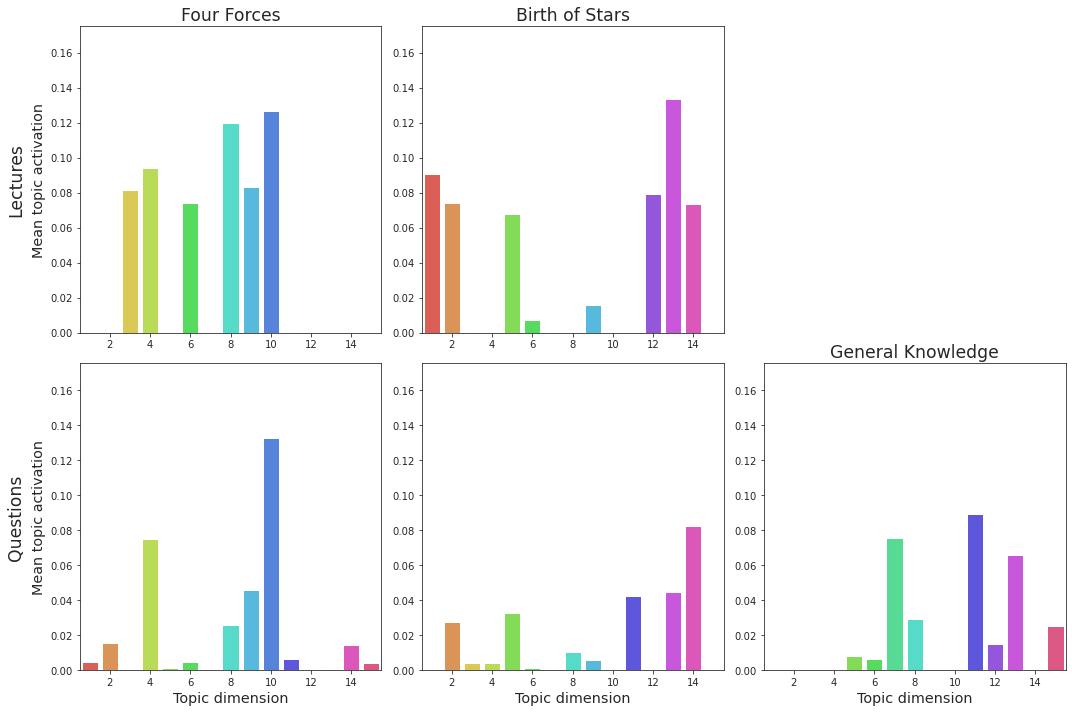

In [23]:
sns.set_style('ticks')
palette = sns.color_palette('hls', 15)

fig, axarr = plt.subplots(2, 3)
fig.set_size_inches(15, 10)
axarr = axarr.flatten()

for i, traj in enumerate([forces_traj, 
                          bos_traj, 
                          None, 
                          all_questions[:15], 
                          all_questions[15:30], 
                          all_questions[30:]]):
    ax = axarr[i]
    if traj is None:
        ax.axis('off')
        continue
        
    topic_vars = np.var(traj, axis=0)
    bars = ax.bar(x=list(range(1, 16)), height=topic_vars, color=palette)
    ax.set_ylim(0, .175)
    ax.set_xlim(.5, 15.5)
    ax.set_xticks(list(range(2, 16, 2)))
    
    if i == 0:
        ax.set_ylabel('Mean topic activation', fontsize='x-large')
        ax.set_title('Four Forces', fontsize='xx-large')
        ax.annotate('Lectures', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                    size='xx-large', rotation=90, ha='right', va='center')
    elif i == 1:
        ax.set_title('Birth of Stars', fontsize='xx-large')
    elif i == 3:
        ax.set_ylabel('Mean topic activation', fontsize='x-large')
        ax.annotate('Questions', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                    size='xx-large', rotation=90, ha='right', va='center')
    elif i == 5:
        ax.set_title('General Knowledge', fontsize='xx-large')
        
    if i > 2:
        ax.set_xlabel('Topic dimension', fontsize='x-large')
        

plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('topics-used.pdf'), bbox_inches='tight')
plt.show()

## Save trajectories and fit models

In [24]:
# np.save(TRAJS_DIR.joinpath('forces_lecture'), forces_traj)
# np.save(TRAJS_DIR.joinpath('bos_lecture'), bos_traj)
# np.save(TRAJS_DIR.joinpath('all_questions'), all_questions)
# np.save(TRAJS_DIR.joinpath('all_answers'), all_answers)
# np.save(RAW_DIR.joinpath('forces_windows'), forces_windows)
# np.save(RAW_DIR.joinpath('bos_windows'), bos_windows)
# np.save(MODELS_DIR.joinpath('fit_CV'), cv)
# np.save(MODELS_DIR.joinpath('fit_LDA'), lda)